In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['structures.csv', 'train.csv', 'potential_energy.csv', 'dipole_moments.csv', 'sample_submission.csv', 'scalar_coupling_contributions.csv', 'mulliken_charges.csv', 'structures', 'magnetic_shielding_tensors.csv', 'test.csv']


In [2]:
# import data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
structures = pd.read_csv("../input/structures.csv")

It's annoying to print the head of a Dataframe in stdout because it will often truncate the columns, so let's write a function to force it to print all columns.

In [3]:
def PrintDataframe(df):
    print(df.to_string())

PrintDataframe(train.head())

   id     molecule_name  atom_index_0  atom_index_1  type  scalar_coupling_constant
0   0  dsgdb9nsd_000001             1             0  1JHC                   84.8076
1   1  dsgdb9nsd_000001             1             2  2JHH                  -11.2570
2   2  dsgdb9nsd_000001             1             3  2JHH                  -11.2548
3   3  dsgdb9nsd_000001             1             4  2JHH                  -11.2543
4   4  dsgdb9nsd_000001             2             0  1JHC                   84.8074


In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


Let's find the number of molecule types, and how many times they appear. Interestingly, the value counts appear normally distributed. In retrospect, this information may not be so useful, since the molecule name will not be used a feature. According to the competition data description, "...no molecule in the training data is found in the test data."

number of unique molecules = 85003


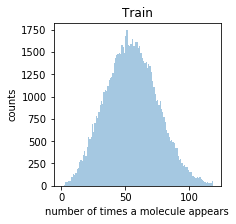

In [5]:
# analyze molecule types
mol_name_col = train.molecule_name
print("number of unique molecules =",len(mol_name_col.unique()))
plt.figure(figsize=(3,3))
plt.ylabel('counts')
plt.xlabel('number of times a molecule appears')
plt.title('Train')
sns.distplot(mol_name_col.value_counts().values,kde=False,bins=range(120))
# cleanup
del mol_name_col

number of unique molecules = 45772


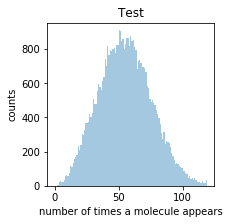

In [6]:
# analyze molecule types
mol_name_col = test.molecule_name
print("number of unique molecules =",len(mol_name_col.unique()))
plt.figure(figsize=(3,3))
plt.ylabel('counts')
plt.xlabel('number of times a molecule appears')
plt.title('Test')
sns.distplot(mol_name_col.value_counts().values,kde=False,bins=range(120))
# cleanup
del mol_name_col

Next consider the coupling types. Notice that they are very unbalanced, but train and test are unbalanced in the same way.

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64 

3JHC    811999
2JHC    613138
1JHC    380609
3JHH    317435
2JHH    203126
3JHN     90616
2JHN     64424
1JHN     24195
Name: type, dtype: int64 



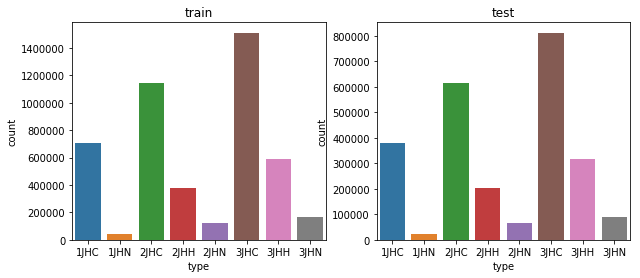

In [7]:
# look at couping types
def VisualizeCounts(*cols):
    """
    takes a dataframe column (i.e. a Series)
    prints the counts and graphs 
    """
    fig, axs = plt.subplots(ncols=len(cols), figsize=(5*len(cols), 4))
    titles = ['train','test']
    for i,col in enumerate(cols):
        print(col.value_counts(),'\n')
        sns.countplot(col,ax = axs[i], order = sorted(col.unique()))
        axs[i].title.set_text(titles[i])

VisualizeCounts(train.type,test.type)

If we consider the scalar coupling values, we see that they are basically clustered around 0, with a peak at around 80.

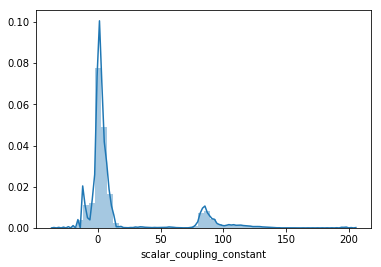

In [8]:
# looking at scalar_coupling values
sns.distplot(train.scalar_coupling_constant)

Let's see how well the coupling type corresponds to the coupling constant.

Note that the coupling type can be easily interpreted. The number prefix tells you how many bonds there are between the two atoms; the last two letters are the two elements involved. For example, 1JHC, means that the coupling is between one hydrogen and one carbon atom, and there is only one bond between them. 

Since the coupling strength is inversely proportional to the number of bonds, 1JHN and 1JHC have the strongest coupling. 

All of the coupling constants are positive except for 2JHH, which is negative. 

Note that since the maximum number of bonds is three, there are at most two atoms in between the atoms of interest. 

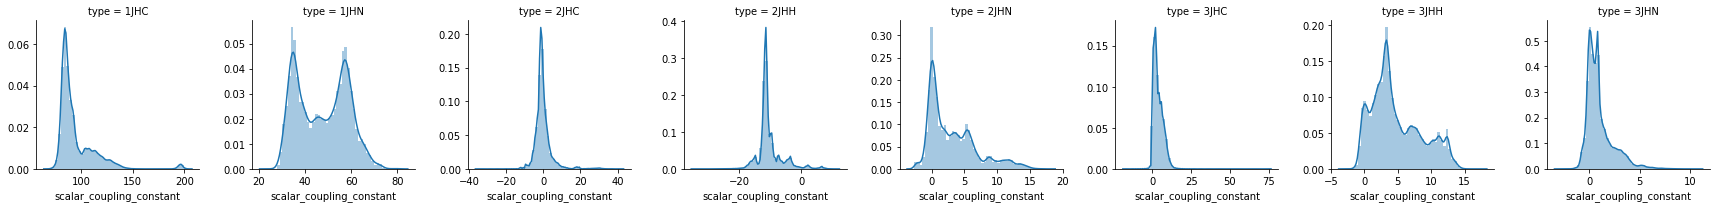

In [9]:
g = sns.FacetGrid(train, col="type", col_order = sorted(train.type.unique()),sharex=False,sharey=False)
g.map(sns.distplot, "scalar_coupling_constant");

We can extract the number of bonds and the atom types just using the coupling type. Note that the first atom in the coupling type is always H. You can confirm by yourself (using some code further down that extracts the atom type from the structures data) that atom_0 is always H. Therefore, we need only extract atom_type_1.

In [10]:
def DecomposeType(df):
    df['num_bonds'] = df.type.map(lambda s: int(s[0]))
    df['atom_1_type'] = df.type.map(lambda s: s[-1])
    df.drop(columns='type',inplace=True)


DecomposeType(train)
DecomposeType(test)

PrintDataframe(train.head())

   id     molecule_name  atom_index_0  atom_index_1  scalar_coupling_constant  num_bonds atom_1_type
0   0  dsgdb9nsd_000001             1             0                   84.8076          1           C
1   1  dsgdb9nsd_000001             1             2                  -11.2570          2           H
2   2  dsgdb9nsd_000001             1             3                  -11.2548          2           H
3   3  dsgdb9nsd_000001             1             4                  -11.2543          2           H
4   4  dsgdb9nsd_000001             2             0                   84.8074          1           C


Let's see what we can get out of structures

In [11]:
PrintDataframe(structures.head())

      molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397


The most obvious feature to extract is the distance between atom 0 and atom 1. I copied the method in this [kernel](https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark) by Chanran Kim

In [12]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop(['atom_index','atom'], axis=1)
    df = df.rename(columns={'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [13]:
train_r0 = train[['x_0', 'y_0', 'z_0']].values
train_r1 = train[['x_1', 'y_1', 'z_1']].values
test_r0 = test[['x_0', 'y_0', 'z_0']].values
test_r1 = test[['x_1', 'y_1', 'z_1']].values

# calculate through space distance
train['space_dr'] = np.linalg.norm(train_r0 - train_r1, axis=1)
test['space_dr'] = np.linalg.norm(test_r0 - test_r1, axis=1)

# drop coordinates
train.drop(columns = ['x_0', 'y_0', 'z_0','x_1', 'y_1', 'z_1'], inplace = True)
test.drop(columns = ['x_0', 'y_0', 'z_0','x_1', 'y_1', 'z_1'], inplace = True)

PrintDataframe(train.head())

   id     molecule_name  atom_index_0  atom_index_1  scalar_coupling_constant  num_bonds atom_1_type  space_dr
0   0  dsgdb9nsd_000001             1             0                   84.8076          1           C  1.091953
1   1  dsgdb9nsd_000001             1             2                  -11.2570          2           H  1.783120
2   2  dsgdb9nsd_000001             1             3                  -11.2548          2           H  1.783147
3   3  dsgdb9nsd_000001             1             4                  -11.2543          2           H  1.783157
4   4  dsgdb9nsd_000001             2             0                   84.8074          1           C  1.091952


It might also be useful to have an idea of what other atoms are in the molecule. 

   id     molecule_name  atom_index_0  atom_index_1  scalar_coupling_constant  num_bonds atom_1_type  space_dr  num_C  num_H  num_N  num_O  num_F  total_atoms
0   0  dsgdb9nsd_000001             1             0                   84.8076          1           C  1.091953    1.0    4.0    0.0    0.0    0.0          5.0
1   1  dsgdb9nsd_000001             1             2                  -11.2570          2           H  1.783120    1.0    4.0    0.0    0.0    0.0          5.0
2   2  dsgdb9nsd_000001             1             3                  -11.2548          2           H  1.783147    1.0    4.0    0.0    0.0    0.0          5.0
3   3  dsgdb9nsd_000001             1             4                  -11.2543          2           H  1.783157    1.0    4.0    0.0    0.0    0.0          5.0
4   4  dsgdb9nsd_000001             2             0                   84.8074          1           C  1.091952    1.0    4.0    0.0    0.0    0.0          5.0


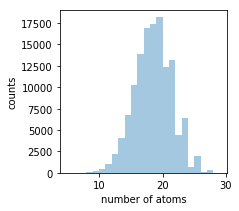

In [14]:
# Group by molecule_name and atom, then use size() to count how many of each atom
# Then use unstack to make the atom types, which groupby made into indices, into columns
# Finally, because not all molecule contain all five atoms, fill NAs with 0
structure_atoms=structures.groupby(['molecule_name','atom'],sort=False).size().unstack('atom').fillna(0)
# calculate the total number of atoms
structure_atoms['total_atoms']=structure_atoms.sum(axis=1)
# remove index names (optional)
structure_atoms.columns = structure_atoms.columns.set_names(None)
structure_atoms.index=structure_atoms.index.set_names(None)
# rename columns
structure_atoms = structure_atoms.rename(columns={'C':'num_C','H':'num_H','N':'num_N',
                                                  'O':'num_O','F':'num_F'})
plt.figure(figsize=(3,3))
#plt.hist(structure_atoms.total_atoms,)
sns.distplot(structure_atoms.total_atoms,kde=False,bins=range(5,30))
plt.ylabel('counts')
plt.xlabel('number of atoms')

# extend train and test
train=pd.merge(train, structure_atoms, how = 'left', 
                     left_on  = ['molecule_name'], right_index = True)

test=pd.merge(test, structure_atoms, how = 'left', 
                     left_on  = ['molecule_name'], right_index = True)

PrintDataframe(train.head())

In [15]:
structure_atoms.describe()

,num_C,num_H,num_N,num_O,num_F,total_atoms
count,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000
mean,6.359977,9.240199,1.012128,1.400780,0.022910,18.035993
std,1.228257,2.813601,1.074136,0.883499,0.214686,2.938363
min,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,6.000000,7.000000,0.000000,1.000000,0.000000,16.000000
50%,6.000000,9.000000,1.000000,1.000000,0.000000,18.000000
75%,7.000000,11.000000,2.000000,2.000000,0.000000,20.000000
max,9.000000,20.000000,7.000000,5.000000,6.000000,29.000000


We can then use this information to confirm that the number of times a molecule appears in either the training set or test set is an indication of the molecule size.

Text(0.5, 0, 'number of atoms')

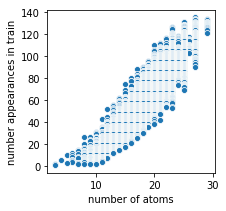

In [16]:
# analyze molecule types
mol_name_col = train.molecule_name
mol_name_counts=mol_name_col.value_counts()
merged=pd.merge(mol_name_counts, structure_atoms, how = 'left', left_index = True, right_index = True)
plt.figure(figsize=(3,3))
sns.scatterplot(x="total_atoms",y="molecule_name", data = merged)
plt.ylabel('number appearances in train')
plt.xlabel('number of atoms')

Text(0.5, 0, 'number of atoms')

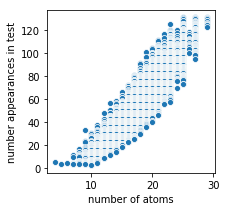

In [17]:
# analyze molecule types
mol_name_col = test.molecule_name
mol_name_counts=mol_name_col.value_counts()
merged=pd.merge(mol_name_counts, structure_atoms, how = 'left', left_index = True, right_index = True)
plt.figure(figsize=(3,3))
sns.scatterplot(x="total_atoms",y="molecule_name", data = merged)
plt.ylabel('number appearances in test')
plt.xlabel('number of atoms')